In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

In [4]:
folder_path = "./MPIIFaceGaze"

if os.path.isdir(folder_path):
    print(f"✅ 資料夾存在：{folder_path}")
else:
    print(f"⚠️ 資料夾不存在：{folder_path}")
    # 如果你想自動建立它可以加上：
    # os.makedirs(folder_path)

✅ 資料夾存在：./MPIIFaceGaze


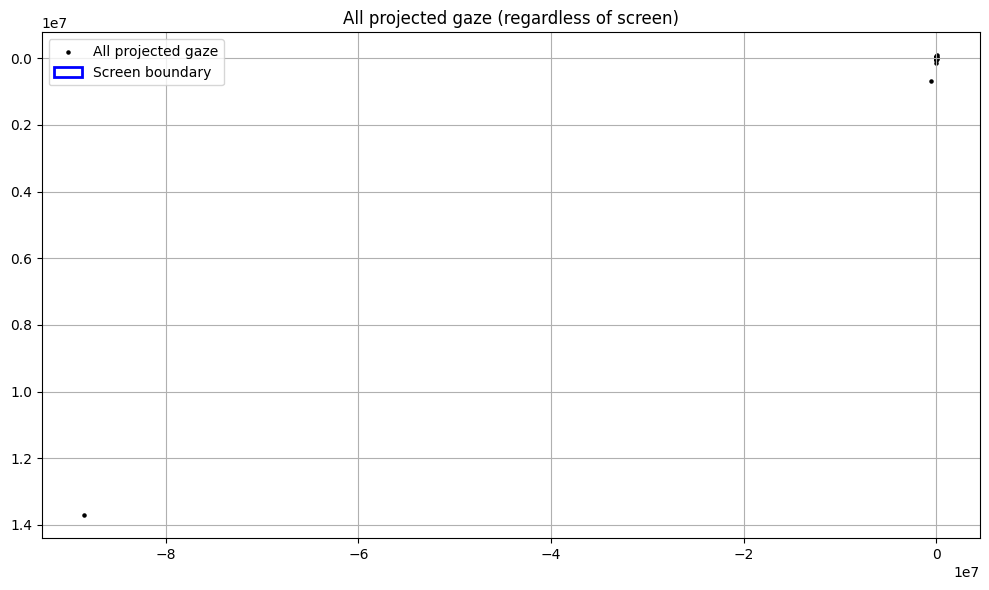

In [13]:
def plot_gaze_projection(base_path, subject_id, camera_mat_path="Camera.mat", screen_mat_path="screenSize.mat"):
    # 檔案路徑
    txt_path = os.path.join(base_path, f"{subject_id}.txt")
    #camera_mat_path = os.path.join(base_path, camera_mat_file)
    #screen_mat_path = os.path.join(base_path, screen_mat_file)

    # 讀取 pitch/yaw（第18和19欄）
    pitch_yaw = []
    with open(txt_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 20:
            try:
                pitch = float(parts[18]) * np.pi / 180
                yaw = float(parts[19]) * np.pi / 180
                pitch_yaw.append([pitch, yaw])
            except ValueError:
                continue

    pitch_yaw = np.array(pitch_yaw)
    if len(pitch_yaw) == 0:
        print(f"[{subject_id}] 沒有有效的 pitch/yaw 資料")
        return

    # pitch/yaw 轉 gaze vector
    pitch = pitch_yaw[:, 0]
    yaw = pitch_yaw[:, 1]
    x = -np.cos(pitch) * np.sin(yaw)
    y = -np.sin(pitch)
    z = -np.cos(pitch) * np.cos(yaw)
    gaze_vectors = np.stack([x, y, z], axis=1)

    # 讀取相機參數
    cam_matrix = loadmat(camera_mat_path)['cameraMatrix']
    fx = cam_matrix[0, 0]
    fy = cam_matrix[1, 1]
    cx = cam_matrix[0, 2]
    cy = cam_matrix[1, 2]

    # 投影 gaze vector 到螢幕平面
    scale = 1
    gx = gaze_vectors[:, 0] * scale
    gy = gaze_vectors[:, 1] * scale
    gz = gaze_vectors[:, 2] * scale

    px = fx * gx / gz + cx
    py = fy * gy / gz + cy

    # 螢幕大小（pixel）
    screen_mat = loadmat(screen_mat_path)
    screen_w = int(screen_mat['width_pixel'][0, 0])
    screen_h = int(screen_mat['height_pixel'][0, 0])

    # 判斷哪些點落在螢幕內
    on_screen_mask = (px >= 0) & (px <= screen_w) & (py >= 0) & (py <= screen_h)
    on_px, on_py = px[on_screen_mask], py[on_screen_mask]
    off_px, off_py = px[~on_screen_mask], py[~on_screen_mask]

    # 畫圖！
    plt.figure(figsize=(10, 6))
    plt.scatter(on_px, on_py, color='green', s=10, label='Gaze on screen')
    plt.scatter(off_px, off_py, color='red', s=10, label='Gaze off screen')
    plt.gca().add_patch(plt.Rectangle((0, 0), screen_w, screen_h, fill=False, color='blue', linewidth=2, label='Screen boundary'))
    plt.xlabel("Screen X (px)")
    plt.ylabel("Screen Y (px)")
    plt.title(f"Gaze Projection for {subject_id}")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ 使用方法：
# 將 base_path 換成你的資料資料夾路徑
plot_gaze_projection(base_path="./MPIIFaceGaze/p02", subject_id="p02",camera_mat_path="./MPIIFaceGaze/p02/Calibration/Camera.mat"
                     ,screen_mat_path="./MPIIFaceGaze/p02/Calibration/screenSize.mat")
